### Imports, plot configuration

In [1]:
# Library imports (see /Utilities/setup_env.py for full import list and figure setup)

from pathlib import Path
import sys

repo_root = Path.cwd().parents[0]  # .../Figure_analysis
repo_root = repo_root.parent       # repo root
sys.path.insert(0, str(repo_root))

from Figure_analysis.Utilities.setup_env import *

### Fetch data from nerd sqlite database

In [2]:
def fetch_fmod_run(
    db_path: str,
    temperature: int,
    selected_fmod_run_id: Optional[int] = None,
    sample_name: Optional[str] = None,
    treated_flag: Optional[int] = None,
    construct_family: Optional[str] = None,
) -> pd.DataFrame:
    """
    Retrieve `probe_fmod_run` rows with sequencing sample, reaction, and construct context.

    Parameters
    ----------
    db_path : str or path-like
        Path to the SQLite database file.
    temperature : int
        Reaction temperature (°C) used to filter probe reactions.
    selected_fmod_run_id : int, optional
        If provided, restrict results to a specific `probe_fmod_run.id`.
    sample_name : str, optional
        If provided, restrict results to a specific sequencing sample name.
    treated_flag : {0, 1}, optional
        If provided, restrict results to treated (1) or untreated (0)
        probe reactions.
    construct_family : str, optional
        If provided, restrict results to constructs belonging to this family
        (matches `meta_constructs.family`).

    Returns
    -------
    pandas.DataFrame
        DataFrame with one row per (fmod_run_id, reaction_time) combination and
        the following columns:

        - ``fmod_run_id`` : int
        - ``output_dir`` : str
        - ``sample_name`` : str
        - ``reaction_time`` : float
        - ``treated`` : int
        - ``construct.disp_name`` : str
    """
    conditions = [
        "pr.temperature = :temperature",
        "s.to_drop = 0",
    ]
    params: Dict[str, object] = {"temperature": temperature}

    if selected_fmod_run_id is not None:
        conditions.append("r.id = :fmod_run_id")
        params["fmod_run_id"] = selected_fmod_run_id

    if sample_name:
        conditions.append("s.sample_name = :sample_name")
        params["sample_name"] = sample_name

    if treated_flag is not None:
        conditions.append("pr.treated = :treated")
        params["treated"] = treated_flag

    if construct_family:
        conditions.append("mc.family = :construct_family")
        params["construct_family"] = construct_family

    where_clause = " AND ".join(conditions)

    query = f"""
        SELECT
            r.id AS fmod_run_id,
            r.output_dir,
            s.sample_name,
            pr.reaction_time,
            pr.treated,
            pr.rg_id,
            mc.disp_name AS "construct.disp_name"
        FROM probe_fmod_runs r
        JOIN sequencing_samples s ON s.id = r.s_id
        JOIN probe_reactions pr ON pr.s_id = s.id
        JOIN meta_constructs mc ON mc.id = pr.construct_id
        WHERE {where_clause}
        ORDER BY r.id, pr.reaction_time
    """

    with sqlite3.connect(db_path) as conn:
        df = pd.read_sql_query(query, conn, params=params)

    return df

#### Main functions

**parse_per_read_hist**

Finds and loads the per-read histogram for a given fmod run by searching the stored output directory and fallback pipeline/repo paths. Parses the histogram file (0,1,2,… mutations per read vs. frequency) and returns both the file locations checked and the loaded histogram table.

**attach_per_read_bin_frequencies**

Uses `parse_per_read_hist` to extract the frequencies of reads with 0, 1, and 2 mutations for each fmod run, and appends these frequencies as new columns (`0mut`, `1mut`, `2mut`) to the provided results DataFrame.

In [3]:
def parse_per_read_hist(
    run_row: pd.Series,
    db_path: str,
    selected_valtype: str,
) -> Dict[str, Any]:
    """
    Locate and parse per-read histogram files on disk for a given fmod run.

    Parameters
    ----------
    run_row : pandas.Series
        Single row from :func:`fetch_fmod_run`. Must contain the columns
        ``fmod_run_id``, ``output_dir``, and ``sample_name``.
    db_path : str or path-like
        Path to the SQLite database; used to infer pipeline and repository roots.
    selected_valtype : {"modrate", "modrateGA"}
        Which histogram type to treat as the primary one.

    Returns
    -------
    dict
        Dictionary with the following keys:

        - ``run`` : pandas.Series
            The input row.
        - ``hist_files`` : dict[str, pathlib.Path]
            Mapping from histogram filename to discovered path.
        - ``checked`` : list[pathlib.Path]
            All paths that were checked for histogram files.
        - ``histogram`` : pandas.DataFrame or None
            Parsed per-read histogram; ``None`` if not found or failed to parse.
        - ``x_label`` : str
            X-axis label corresponding to ``selected_valtype``.

    Raises
    ------
    ValueError
        If ``selected_valtype`` is not one of ``{"modrate", "modrateGA"}``.
    """
    hist_meta = {
        "modrate": ("per_read_histogram.txt", "Mutations per read"),
        "modrateGA": ("per_read_histogram.txtga", "GA mismatches per read"),
    }
    if selected_valtype not in hist_meta:
        raise ValueError(
            "`selected_valtype` must be either 'modrate' or 'modrateGA' for per-read histograms."
        )

    hist_filename, x_label = hist_meta[selected_valtype]

    sample_name = run_row["sample_name"]
    raw_output_dir = run_row["output_dir"]
    fmod_run_id = run_row["fmod_run_id"]

    print(f"Run {fmod_run_id} (sample: {sample_name})")
    print(f"Stored output_dir: {raw_output_dir}")

    output_path = Path(raw_output_dir).expanduser()
    pipeline_root = Path(db_path).resolve().parent if db_path is not None else Path.cwd()
    repo_root = pipeline_root.parent

    def _candidate_dirs():
        """Yield candidate directories to search for histogram files."""
        seen = set()

        def _emit(path: Path):
            key = str(path)
            if key not in seen:
                seen.add(key)
                yield path

        # 1) The stored directory itself
        for item in _emit(output_path):
            yield item

        # 2) Variants under pipeline_root / repo_root if "mut_count" appears in the path
        parts = output_path.parts
        if "mut_count" in parts:
            last_idx = max(i for i, part in enumerate(parts) if part == "mut_count")
            suffix = Path(*parts[last_idx:])
            for base in (
                pipeline_root,
                pipeline_root / "04_run_mutcounts",
                repo_root,
                repo_root / "examples",
            ):
                candidate = base / suffix
                for item in _emit(candidate):
                    yield item

    checked = []
    found: Dict[str, Path] = {}

    for dir_candidate in _candidate_dirs():
        for filename in ("per_read_histogram.txt", "per_read_histogram.txtga"):
            hist_path = dir_candidate / filename
            checked.append(hist_path)
            if hist_path.exists():
                found[filename] = hist_path

    if found:
        for name, path in found.items():
            print(f"✓ Found {name} at {path}")
    else:
        print("No histogram files found. Checked the following paths:")
        for path in checked:
            print(f" - {path}")

    hist_path = found.get(hist_filename)
    hist_df: Optional[pd.DataFrame] = None
    if hist_path is not None:
        try:
            hist_df = pd.read_csv(hist_path, sep="\t").sort_values("bin_left")
        except Exception as exc:  # noqa: BLE001
            print(f"Failed to read {hist_path}: {exc}")

    return {
        "run": run_row,
        "hist_files": found,
        "checked": checked,
        "histogram": hist_df,
        "x_label": x_label,
    }

def attach_per_read_bin_frequencies(
    db_path: str,
    result_df: pd.DataFrame,
    selected_valtype: str = "modrate",
) -> pd.DataFrame:
    """
    Annotate each fmod run with 0/1/2-mutation bin frequencies from per-read histograms.

    For every row in ``result_df``, this function locates the corresponding per-read
    histogram (via :func:`parse_per_read_hist`) and attaches the frequencies of
    reads with 0, 1, or 2 mutations.

    Parameters
    ----------
    db_path : str or path-like
        Path to the SQLite database file. Used by :func:`parse_per_read_hist` to
        infer pipeline and repository roots.
    result_df : pandas.DataFrame
        DataFrame containing one row per fmod run. Must include at least the
        columns ``fmod_run_id``, ``output_dir``, ``sample_name``, and
        ``reaction_time``.
    selected_valtype : {"modrate", "modrateGA"}, optional
        Histogram type to use. ``"modrate"`` corresponds to
        ``per_read_histogram.txt``, while ``"modrateGA"`` corresponds to
        ``per_read_histogram.txtga``. Default is ``"modrate"``.

    Returns
    -------
    pandas.DataFrame
        Copy of ``result_df`` with three additional columns:

        - ``0mut`` : float
        - ``1mut`` : float
        - ``2mut`` : float

        representing the frequency of reads with 0, 1, and 2 mutations,
        respectively. If a histogram is missing, values remain ``NaN``.
    """
    bins = [0, 1, 2]
    annotated = result_df.copy()
    for b in bins:
        annotated[f"{b}mut"] = np.nan

    for idx, row in annotated.iterrows():
        lookup = parse_per_read_hist(row, db_path, selected_valtype)
        hist_df = (lookup or {}).get("histogram")
        if hist_df is None:
            continue

        freq_map = dict(zip(hist_df["bin_left"].astype(int), hist_df["frequency"]))
        for b in bins:
            annotated.at[idx, f"{b}mut"] = float(freq_map.get(b, 0.0))

    return annotated

#### Plotting functions

In [6]:
def plot_histogram(
    hist_df: Optional[pd.DataFrame],
    selected_fmod_run_id: int,
    x_label: str,
    figsize: Tuple[float, float] = (6, 3),
):
    """
    Plot a per-read histogram DataFrame.

    Parameters
    ----------
    hist_df : pandas.DataFrame or None
        Histogram data. Must contain columns ``bin_left`` and ``frequency``.
        If ``None`` or empty, no plot is produced.
    selected_fmod_run_id : int
        Identifier of the fmod run; used in the plot title.
    x_label : str
        X-axis label (depends on ``selected_valtype``).
    figsize : tuple of float, optional
        Figure size in inches, by default ``(6, 3)``.

    Returns
    -------
    fig : matplotlib.figure.Figure or None
        Created figure, or ``None`` if nothing was plotted.
    ax : matplotlib.axes.Axes or None
        Created axes, or ``None`` if nothing was plotted.
    """
    if hist_df is None or hist_df.empty:
        print("No histogram data to plot.")
        return None, None

    fig, ax = plt.subplots(figsize=figsize)
    ax.bar(hist_df["bin_left"], hist_df["frequency"], width=0.9, alpha=0.7)
    ax.set_xlabel(x_label)
    ax.set_ylabel("Frequency")
    ax.set_title(f"Per-read histogram – run {selected_fmod_run_id}")
    ax.set_xticks(hist_df["bin_left"].astype(int))
    ax.set_ylim(0, hist_df["frequency"].max() * 1.05)
    ax.margins(x=0)
    plt.tight_layout()

    return fig, ax

def plot_muts_frequency(
    result_df: pd.DataFrame,
    out_name: str,
):
    """
    Plot frequencies of reads with 0, 1, and 2 mutations as a function of reaction time.
    """
    fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    # Melt to long format
    plot_df = result_df.melt(
        id_vars="reaction_time",
        value_vars=["0mut", "1mut", "2mut"],
        var_name="mutation_class",
        value_name="frequency",
    )

    # Consistent color scheme
    palette = {
        "0mut": "#66c2a5",
        "1mut": "#fc8d62",
        "2mut": "#8da0cb",
    }

    label_map = {
        "0mut": "0 muts per read",
        "1mut": "1 mut per read",
        "2mut": "2 muts per read",
    }

    sns.scatterplot(
        data=plot_df,
        x="reaction_time",
        y="frequency",
        hue="mutation_class",
        palette=palette,
        ax=ax,
        s=20,
        legend=True,
    )

    # Fix legend labels
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        handles,
        [label_map[l] for l in labels],
        frameon=False,
        title=None,
    )

    # Print ratio
    ratio_2muts = result_df["2mut"].mean() / result_df["1mut"].mean()
    print(f"Ratio 2:1 muts per read: {ratio_2muts:.4f}")

    # always start at 0 xlim
    ax.set_xlim(left=0)

    ax.set_ylabel("Frequency")
    ax.set_xlabel("Reaction Time (s)")

    plt.tight_layout()
    plt.savefig(f"mutation_freq_{out_name}.pdf")
    plt.show()

    return fig, ax

### Execution of functions (run cells below)

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


Run 352 (sample: 031_fourU_WT_25c_b_1_p)
Stored output_dir: /gpfs/projects/b1044/Computational_Output/EKC/EKC.01_SHAPE_standardization/EKC.01.065.refactoring_data_analysis/nerd/examples/all_mutcounts/mut_count/mut_count___cfg-3733403/artifacts/031_fourU_WT_25c_b_1_p
✓ Found per_read_histogram.txt at /Volumes/MiniVault/LucksLab Dropbox/LucksLab/Group_Members/EKC/Projects/EKC.07.nerd/Choi_PRIME_Chemprobing_2026/Core_nerd_analysis/04_run_mutcounts/mut_count/mut_count___cfg-3733403/artifacts/031_fourU_WT_25c_b_1_p/per_read_histogram.txt
✓ Found per_read_histogram.txtga at /Volumes/MiniVault/LucksLab Dropbox/LucksLab/Group_Members/EKC/Projects/EKC.07.nerd/Choi_PRIME_Chemprobing_2026/Core_nerd_analysis/04_run_mutcounts/mut_count/mut_count___cfg-3733403/artifacts/031_fourU_WT_25c_b_1_p/per_read_histogram.txtga
Run 353 (sample: 032_fourU_WT_25c_b_2_p)
Stored output_dir: /gpfs/projects/b1044/Computational_Output/EKC/EKC.01_SHAPE_standardization/EKC.01.065.refactoring_data_analysis/nerd/examples

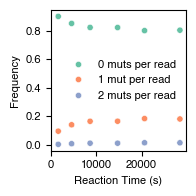

(<Figure size 200x200 with 1 Axes>,
 <Axes: xlabel='Reaction Time (s)', ylabel='Frequency'>)

In [7]:
NERD_SQLITE = '../../Core_nerd_analysis/nerd.sqlite'

# 25°C (representative rg 80)
fmod_runs = fetch_fmod_run(NERD_SQLITE, temperature = 25, construct_family = 'Salm_4U_thermometer', treated_flag=1)
fmod_runs = fmod_runs[fmod_runs['construct.disp_name'] == '4U_wt']
fmod_runs = fmod_runs[fmod_runs['rg_id'] == 80]

result_df = attach_per_read_bin_frequencies(NERD_SQLITE, fmod_runs, selected_valtype="modrate")

# print last row (for final values)
print(result_df.tail())

plot_muts_frequency(result_df, '25C_4Uwt')

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


Run 265 (sample: 001_fourU_WT_18c_a_1_p)
Stored output_dir: /gpfs/projects/b1044/Computational_Output/EKC/EKC.01_SHAPE_standardization/EKC.01.065.refactoring_data_analysis/nerd/examples/all_mutcounts/mut_count/mut_count___cfg-453b76a/artifacts/001_fourU_WT_18c_a_1_p
✓ Found per_read_histogram.txt at /Volumes/MiniVault/LucksLab Dropbox/LucksLab/Group_Members/EKC/Projects/EKC.07.nerd/Choi_PRIME_Chemprobing_2026/Core_nerd_analysis/04_run_mutcounts/mut_count/mut_count___cfg-453b76a/artifacts/001_fourU_WT_18c_a_1_p/per_read_histogram.txt
✓ Found per_read_histogram.txtga at /Volumes/MiniVault/LucksLab Dropbox/LucksLab/Group_Members/EKC/Projects/EKC.07.nerd/Choi_PRIME_Chemprobing_2026/Core_nerd_analysis/04_run_mutcounts/mut_count/mut_count___cfg-453b76a/artifacts/001_fourU_WT_18c_a_1_p/per_read_histogram.txtga
Run 266 (sample: 002_fourU_WT_18c_a_2_p)
Stored output_dir: /gpfs/projects/b1044/Computational_Output/EKC/EKC.01_SHAPE_standardization/EKC.01.065.refactoring_data_analysis/nerd/examples

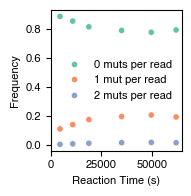

(<Figure size 200x200 with 1 Axes>,
 <Axes: xlabel='Reaction Time (s)', ylabel='Frequency'>)

In [8]:
# 18°C (representative rg 75)
fmod_runs = fetch_fmod_run(NERD_SQLITE, temperature = 18, construct_family = 'Salm_4U_thermometer', treated_flag = 1)
fmod_runs = fmod_runs[fmod_runs['construct.disp_name'] == '4U_wt']
fmod_runs = fmod_runs[fmod_runs['rg_id'] == 75]

result_df = attach_per_read_bin_frequencies(NERD_SQLITE, fmod_runs, selected_valtype="modrate")

# print last row (for final values)
print(result_df.tail())

plot_muts_frequency(result_df, '18C_4Uwt')

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


Run 538 (sample: 037_fourU_WT_37c_b_1_p)
Stored output_dir: /gpfs/projects/b1044/Computational_Output/EKC/EKC.01_SHAPE_standardization/EKC.01.065.refactoring_data_analysis/nerd/examples/all_mutcounts/mut_count/mut_count___cfg-22574be/artifacts/037_fourU_WT_37c_b_1_p
✓ Found per_read_histogram.txt at /Volumes/MiniVault/LucksLab Dropbox/LucksLab/Group_Members/EKC/Projects/EKC.07.nerd/Choi_PRIME_Chemprobing_2026/Core_nerd_analysis/04_run_mutcounts/mut_count/mut_count___cfg-22574be/artifacts/037_fourU_WT_37c_b_1_p/per_read_histogram.txt
✓ Found per_read_histogram.txtga at /Volumes/MiniVault/LucksLab Dropbox/LucksLab/Group_Members/EKC/Projects/EKC.07.nerd/Choi_PRIME_Chemprobing_2026/Core_nerd_analysis/04_run_mutcounts/mut_count/mut_count___cfg-22574be/artifacts/037_fourU_WT_37c_b_1_p/per_read_histogram.txtga
Run 539 (sample: 038_fourU_WT_37c_b_2_p)
Stored output_dir: /gpfs/projects/b1044/Computational_Output/EKC/EKC.01_SHAPE_standardization/EKC.01.065.refactoring_data_analysis/nerd/examples

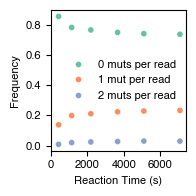

(<Figure size 200x200 with 1 Axes>,
 <Axes: xlabel='Reaction Time (s)', ylabel='Frequency'>)

In [9]:
# 37°C (representative rg 81)
fmod_runs = fetch_fmod_run(NERD_SQLITE, temperature = 37, construct_family = 'Salm_4U_thermometer', treated_flag=1)
fmod_runs = fmod_runs[fmod_runs['construct.disp_name'] == '4U_wt']
fmod_runs = fmod_runs[fmod_runs['rg_id'] == 81]

result_df = attach_per_read_bin_frequencies(NERD_SQLITE, fmod_runs, selected_valtype="modrate")
# print last row
print(result_df.tail())
plot_muts_frequency(result_df, '37C_4Uwt')

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


Run 476 (sample: 079-EKC-WT-50c-a-1-p)
Stored output_dir: /gpfs/projects/b1044/Computational_Output/EKC/EKC.01_SHAPE_standardization/EKC.01.065.refactoring_data_analysis/nerd/examples/all_mutcounts/mut_count/mut_count___cfg-7d8d8d4/artifacts/079-EKC-WT-50c-a-1-p
✓ Found per_read_histogram.txt at /Volumes/MiniVault/LucksLab Dropbox/LucksLab/Group_Members/EKC/Projects/EKC.07.nerd/Choi_PRIME_Chemprobing_2026/Core_nerd_analysis/04_run_mutcounts/mut_count/mut_count___cfg-7d8d8d4/artifacts/079-EKC-WT-50c-a-1-p/per_read_histogram.txt
✓ Found per_read_histogram.txtga at /Volumes/MiniVault/LucksLab Dropbox/LucksLab/Group_Members/EKC/Projects/EKC.07.nerd/Choi_PRIME_Chemprobing_2026/Core_nerd_analysis/04_run_mutcounts/mut_count/mut_count___cfg-7d8d8d4/artifacts/079-EKC-WT-50c-a-1-p/per_read_histogram.txtga
Run 478 (sample: 080-EKC-WT-50c-a-2-p)
Stored output_dir: /gpfs/projects/b1044/Computational_Output/EKC/EKC.01_SHAPE_standardization/EKC.01.065.refactoring_data_analysis/nerd/examples/all_mutco

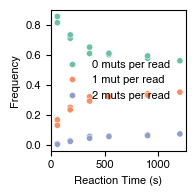

(<Figure size 200x200 with 1 Axes>,
 <Axes: xlabel='Reaction Time (s)', ylabel='Frequency'>)

In [10]:
# 52°C (representative rg 11)
fmod_runs = fetch_fmod_run(NERD_SQLITE, temperature = 52, construct_family = 'Salm_4U_thermometer', treated_flag = 1)
fmod_runs = fmod_runs[fmod_runs['construct.disp_name'] == '4U_wt']
#fmod_runs = fmod_runs[fmod_runs['rg_id'] == 11]

result_df = attach_per_read_bin_frequencies(NERD_SQLITE, fmod_runs, selected_valtype="modrate")
print(result_df.tail())
plot_muts_frequency(result_df, '52C_4Uwt')

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


Run 601 (sample: 007-fourU-WT-65c-b-1-p)
Stored output_dir: /gpfs/projects/b1044/Computational_Output/EKC/EKC.01_SHAPE_standardization/EKC.01.065.refactoring_data_analysis/nerd/examples/all_mutcounts/mut_count/mut_count___cfg-34a5274/artifacts/007-fourU-WT-65c-b-1-p
✓ Found per_read_histogram.txt at /Volumes/MiniVault/LucksLab Dropbox/LucksLab/Group_Members/EKC/Projects/EKC.07.nerd/Choi_PRIME_Chemprobing_2026/Core_nerd_analysis/04_run_mutcounts/mut_count/mut_count___cfg-34a5274/artifacts/007-fourU-WT-65c-b-1-p/per_read_histogram.txt
✓ Found per_read_histogram.txtga at /Volumes/MiniVault/LucksLab Dropbox/LucksLab/Group_Members/EKC/Projects/EKC.07.nerd/Choi_PRIME_Chemprobing_2026/Core_nerd_analysis/04_run_mutcounts/mut_count/mut_count___cfg-34a5274/artifacts/007-fourU-WT-65c-b-1-p/per_read_histogram.txtga
Run 602 (sample: 008-fourU-WT-65c-b-2-p)
Stored output_dir: /gpfs/projects/b1044/Computational_Output/EKC/EKC.01_SHAPE_standardization/EKC.01.065.refactoring_data_analysis/nerd/examples

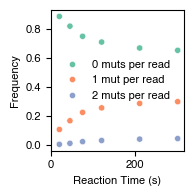

(<Figure size 200x200 with 1 Axes>,
 <Axes: xlabel='Reaction Time (s)', ylabel='Frequency'>)

In [11]:
# 65°C (representative rg_id 44)
fmod_runs = fetch_fmod_run(NERD_SQLITE, temperature = 65, construct_family = 'Salm_4U_thermometer', treated_flag = 1)
fmod_runs = fmod_runs[fmod_runs['construct.disp_name'] == '4U_wt']
fmod_runs = fmod_runs[fmod_runs['rg_id'] == 44]

result_df = attach_per_read_bin_frequencies(NERD_SQLITE, fmod_runs, selected_valtype="modrate")
print(result_df.tail())

plot_muts_frequency(result_df, '65C_4Uwt')

Run 821 (sample: 019-fourU-WT-70c-b-1-p)
Stored output_dir: /gpfs/projects/b1044/Computational_Output/EKC/EKC.01_SHAPE_standardization/EKC.01.065.refactoring_data_analysis/nerd/examples/all_mutcounts/mut_count/mut_count___cfg-f2dd994/artifacts/019-fourU-WT-70c-b-1-p
✓ Found per_read_histogram.txt at /Volumes/MiniVault/LucksLab Dropbox/LucksLab/Group_Members/EKC/Projects/EKC.07.nerd/Choi_PRIME_Chemprobing_2026/Core_nerd_analysis/04_run_mutcounts/mut_count/mut_count___cfg-f2dd994/artifacts/019-fourU-WT-70c-b-1-p/per_read_histogram.txt
✓ Found per_read_histogram.txtga at /Volumes/MiniVault/LucksLab Dropbox/LucksLab/Group_Members/EKC/Projects/EKC.07.nerd/Choi_PRIME_Chemprobing_2026/Core_nerd_analysis/04_run_mutcounts/mut_count/mut_count___cfg-f2dd994/artifacts/019-fourU-WT-70c-b-1-p/per_read_histogram.txtga
Run 822 (sample: 020-fourU-WT-70c-b-2-p)
Stored output_dir: /gpfs/projects/b1044/Computational_Output/EKC/EKC.01_SHAPE_standardization/EKC.01.065.refactoring_data_analysis/nerd/examples

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


Ratio 2:1 muts per read: 0.1053


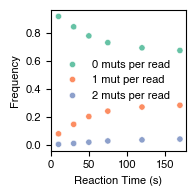

(<Figure size 200x200 with 1 Axes>,
 <Axes: xlabel='Reaction Time (s)', ylabel='Frequency'>)

In [12]:
# 70°C (representative rg_id 46)
fmod_runs = fetch_fmod_run(NERD_SQLITE, temperature = 70, construct_family = 'Salm_4U_thermometer', treated_flag = 1)
fmod_runs = fmod_runs[fmod_runs['construct.disp_name'] == '4U_wt']
fmod_runs = fmod_runs[fmod_runs['rg_id'] == 46]

result_df = attach_per_read_bin_frequencies(NERD_SQLITE, fmod_runs, selected_valtype="modrate")
print(result_df.tail())

plot_muts_frequency(result_df, '70C_4Uwt')